## Object Detection

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import os

## Dataset: Common Object in Context (COCO) 2014

In [2]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
dataset_name = 'train2014' 
ann_file = f"../annotations/instances_{dataset_name}.json"
coco_train = COCO(ann_file)

loading annotations into memory...
Done (t=5.21s)
creating index...
index created!


In [4]:
cat_index_map = {}
for i, id in enumerate(coco_train.getCatIds()):
    cat_index_map[id] = i 

In [5]:
img_id = 521917
img_dict = coco_train.loadImgs(ids=[img_id])[0]
img = io.imread(img_dict['coco_url'])
type(img)

numpy.ndarray

(429, 640, 3)


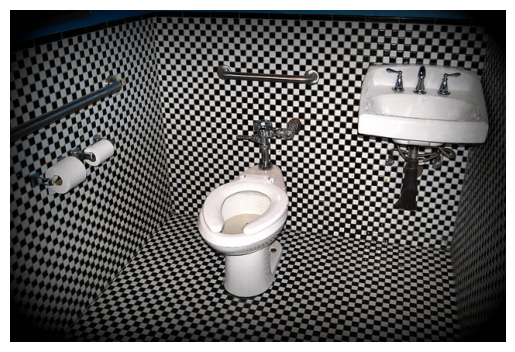

In [6]:
# coco_train.info()
# Display a random image and its labels
idx = np.random.randint(len(coco_train.imgs))
img_id = coco_train.getImgIds()[idx]
img_dict = coco_train.loadImgs(ids=[img_id])[0]

img = io.imread(img_dict['coco_url'])
print(img.shape)
plt.axis('off')
plt.imshow(img)
plt.show()

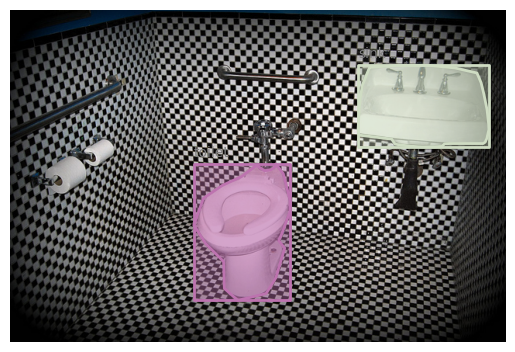

In [7]:
plt.imshow(img); plt.axis('off')
annIds = coco_train.getAnnIds(imgIds=img_dict['id'])
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns, draw_bbox=True)
for ann in anns:
    x,y = ann['bbox'][:2]
    label = coco_train.loadCats([ann['category_id']])[0]['name']
    plt.text(x,y-10, label, color='gray')

In [8]:
from coco_dataset import *
# trainset_classify = CocoDataset(coco_train, img_root='train2014', transforms=classify_transforms, classify=True)
# trainset_detect = CocoDataset(coco_train, img_root='train2014', transforms=detect_transforms, classify=False)
trainset_classify = CocoSingleClassify(coco_train, img_root='../train2014')

len(trainset_classify)

/home/userc/ml_env/lib/python3.14/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


604907

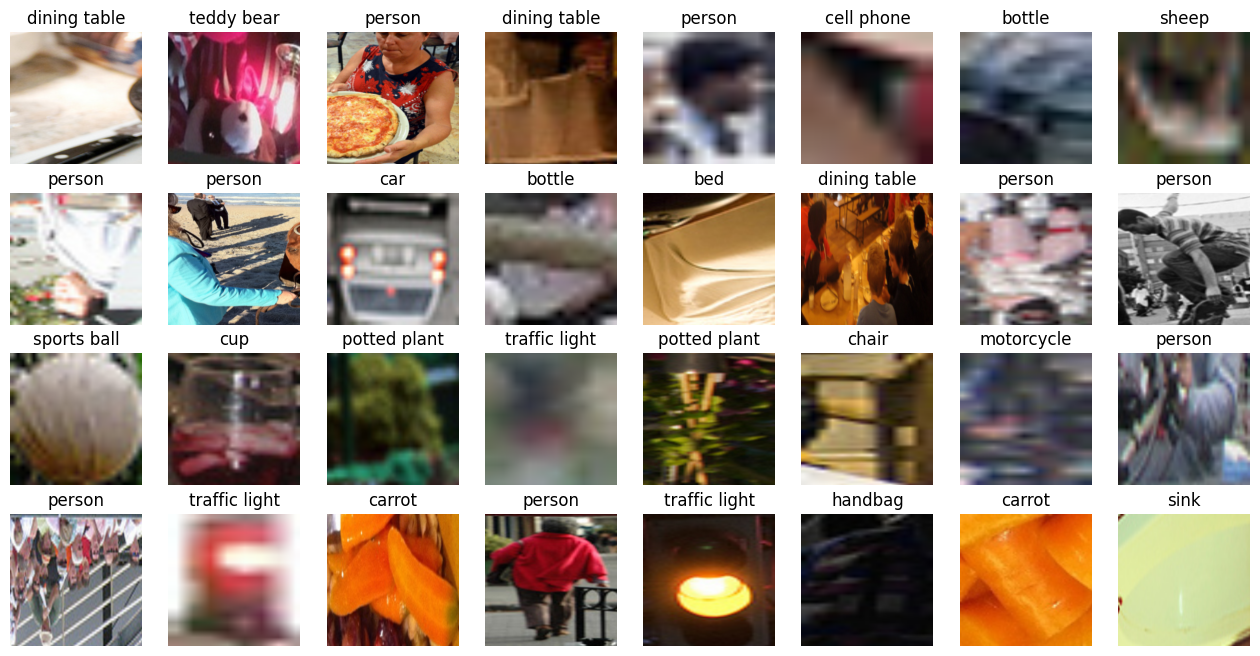

In [13]:
fig, axs = plt.subplots(4,8, figsize=(16, 8))
axs = axs.flatten()

for i in range(32):
    j = np.random.randint(len(trainset_classify))
    img, label = trainset_classify[j]
    axs[i].imshow(img.permute(1,2,0))
    axs[i].set_title(coco_train.loadCats([coco_train.getCatIds()[torch.argmax(label)]])[0]['name'])
    axs[i].set_axis_off()

## R-CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


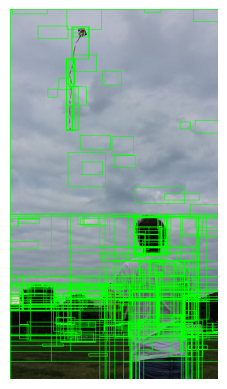

In [11]:
img, label, _ = trainset_detect[8008]
img = img.permute(1,2,0).numpy()
## Code excerpts from github.com/Hulkido/RCNN
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
_img = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(_img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(_img); plt.axis('off')

def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
def to_coords(x, y, w, h):
        c = {}
        c['x1'], c['y1'] = x, y
        c['x2'], c['y2'] = x+w, y+h
        return c
    
def get_tuples(img, labels):    
    iou_thresh=0.69
    ret = []
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rps = ss.process() # region proposals
    for rp in rps:
        for label in labels:
            if get_iou(to_coords(*rp), to_coords(*label[0])) > iou_thresh:
                ret.append((rp, label[0], label[1]))

    return ret

tuple_lists = []
_imgs = []

for i in range(8):
    img, target, img_id = trainset_detect[i]
    _img = img.permute(1,2,0).numpy().copy()
    _imgs.append(_img)
    annIds = coco_train.getAnnIds(img_id)
    anns = coco_train.loadAnns(annIds)
    labels = [( ann['bbox'], coco_train.loadCats(ann['category_id'])[0]['name'])  for ann in anns]
    tuple_lists.append(get_tuples(_img, labels))

for lst in tuple_lists:
    objs = [t[2] for t in lst]
    print(set(objs))
    print()

{'potted plant', 'chair', 'dining table', 'book'}

{'person', 'cake', 'donut'}

{'person'}

{'oven'}

{'oven', 'person'}

{'person', 'chair'}

{'book', 'chair', 'dining table', 'clock'}

{'person', 'bus', 'backpack'}



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

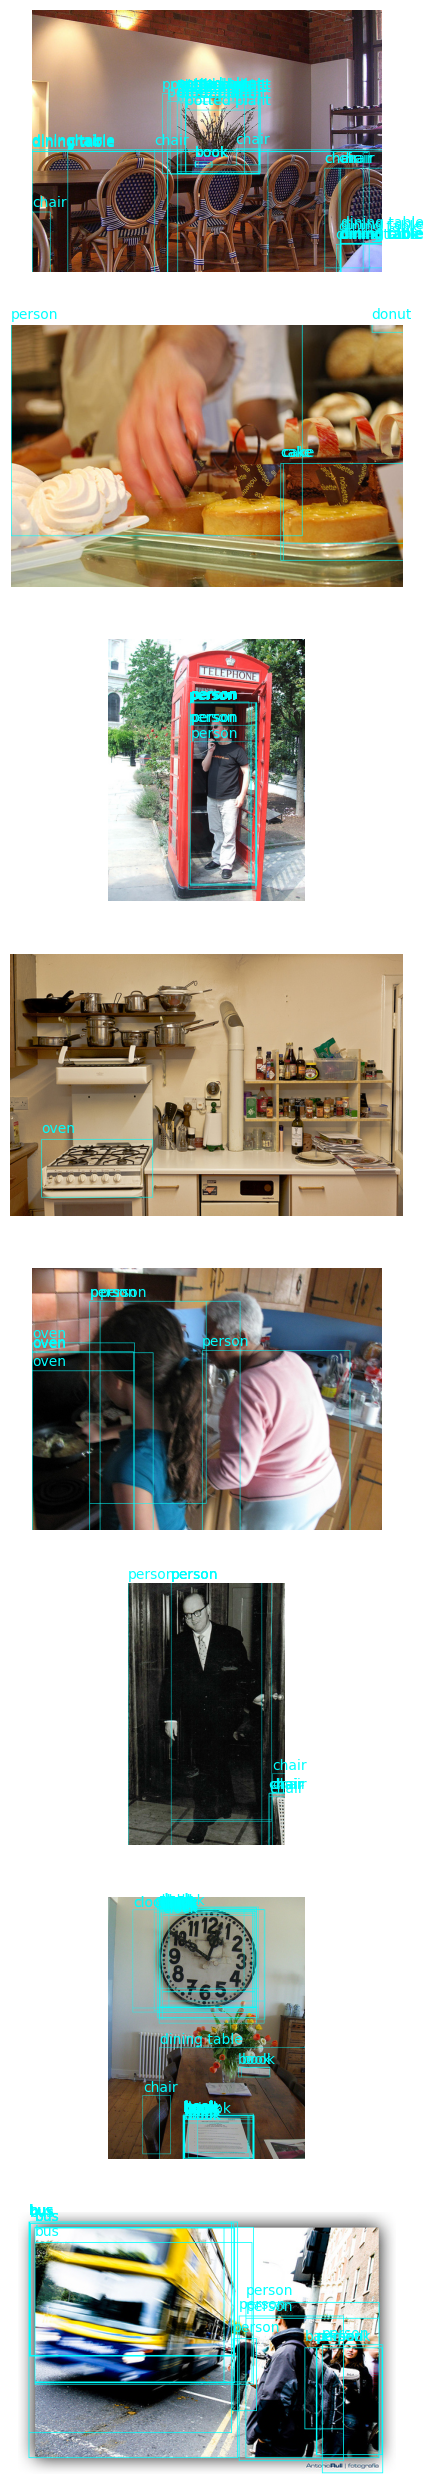

In [13]:
# show valid region proposals
fig, axs = plt.subplots(8,1, figsize=(32,32))
axs = axs.flatten()
for i, lst in enumerate(tuple_lists):
    _img = _imgs[i]
    for tup in lst:
        x, y, w, h = tup[0]
        cv2.rectangle(_img, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
        axs[i].text(x,y-10, tup[2], color='cyan')

    axs[i].imshow(_img)
    axs[i].set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(np.float64(-0.5), np.float64(479.5), np.float64(639.5), np.float64(-0.5))

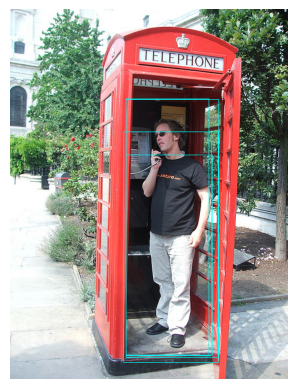

In [14]:
def reduce_overlap(labeled_rps, iou_thresh=0.9):
    # print(len(labeled_rps))
    for i, lrp_a in enumerate(labeled_rps):
        box_a, label_a = lrp_a
        # Delete from list in reverse (Debug Ref: ChatGPT 5.2)
        for j in range(len(labeled_rps)-1, i, -1):
            box_b, label_b = labeled_rps[j]
            if get_iou(to_coords(*box_a), to_coords(*box_b)) > iou_thresh and label_a == label_b:
                # print('delete')
                labeled_rps.pop(j)

    # print(len(labeled_rps))
    return labeled_rps

tups = tuple_lists[2]
lrps = [(t[0],t[2]) for t in tups]
lrps = reduce_overlap(lrps)

img, _, _ = trainset_detect[2]
_img = img.permute(1,2,0).numpy().copy()
for lrp in lrps:
    x, y, w, h = lrp[0]
    cv2.rectangle(_img, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
    # plt.text(x,y-10, tup[1], color='cyan')

plt.imshow(_img)
plt.axis('off')

In [22]:
_resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
resnet = torchvision.models.resnet50(num_classes=80)
children = list(resnet.children())

# transfer weights (Ref: Lab 4)
for m, _m in zip(list(resnet.children())[:-1], _resnet.children()):
    m.load_state_dict(_m.state_dict())
    m.requires_grad = True
    
resnet.fc.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/userc/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.7MB/s]


In [24]:
from tqdm import tqdm

trainset_classify = CocoDataset(coco_train, img_root='train2014', transforms=classify_transforms, classify=True)
trainset_detect = CocoDataset(coco_train, img_root='train2014', transforms=detect_transforms, classify=False)
train_loader = DataLoader(trainset_classify, batch_size=64, shuffle=True)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.005)

for i in range(16): 
    for imgs, labels, _ in tqdm(train_loader):
        logits = resnet(imgs)
        loss = loss_fn(logits, labels)
        loss.backward() # backprop
        optimizer.step()
        optimizer.zero_grad()
    

 13%|█████▎                                    | 20/157 [03:42<25:26, 11.14s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(resnet.state_dict(), "resnet50_coco.pt")

In [20]:
# get validset acc.
dataset_name = 'val2014' 
ann_file = f"annotations/instances_{dataset_name}.json"
coco_valid = COCO(ann_file)
validset_classify = CocoDataset(coco_valid, img_root='val2014', transforms=classify_transforms, classify=True, size=2000)
validset_detect = CocoDataset(coco_valid, img_root='val2014', transforms=detect_transforms, classify=False, size=2000)

valid_loader = DataLoader(validset_classify, batch_size=64, shuffle=True)

correct = 0
total = 0
for imgs, labels, _ in valid_loader:
    logits = resnet(imgs)
    preds = logits > 0  
    correct += (preds == labels).sum()
    total += len(labels)


print("Valid set acc: ", correct / total)

loading annotations into memory...
Done (t=2.76s)
creating index...
index created!
Valid set acc:  tensor(61.1360)


In [ ]:
# Ref: DAT494_Transposed_CNNs.ipynb
feature_cnn = nn.Sequential(*list(resnet.children())[:-1])
# feature_cnn

In [ ]:
class BBoxDataset(Dataset):
    def __init__(self, rp_crops, rps, gts, targets):
        self.rp_crops = rp_crops
        self.rps = rps
        self.gts = gts
        self.targets = targets

    def __len__(self):
        return len(self.rps)
        
    def __getitem__(self, idx):
        return self.rp_crops[idx], torch.tensor(self.rps[idx]), \
            torch.tensor(self.gts[idx]), torch.tensor(self.targets[idx])



In [ ]:
# For single class
class RegressionDataset(Dataset):
    ## get bboxes from selective search
    # that overlap with bboxes from dataset
    def __init__(self, target, rps, rp_crops, gts, feature_cnn):
        self.transforms = transforms.Compose([
            transforms.Resize(size=(256,256))
        ])
        
        self.target = target # class
        self.rps = rps
        self.pooled_features = []
        self.gts = []  # ground truths

        for img in rp_crops:
            img = self.transforms(img)
            self.pooled_features.append(feature_cnn(img))

        # convert to center xy
        # for i in range(len(rps)):
        #     rp = rps[i]
        #     x, y, w, h = rp
        #     x = x + w/2
        #     y = y + h/2
        #     rps[i] = (x, y, w, h)
    
    def add_sample(self, rp, features, gt, target):
        assert target == self.target
        self.rps.append(rp)
        self.pooled_features = features
        self.gts.append(gts)
        
    def __len__(self):
        return len(self.rps)

    def __getitem__(self, idx):
        return torch.tensor(self.rps[idx]), self.pooled_features[idx], torch.tensor(self.gts[idx])

In [ ]:
regression_transforms = transforms.Compose([
    transforms.Resize(size=(256,256))
        ])

rp_crops = []
rps = []
gts = []
targets = []
for i in tqdm(range(64)):
    img, _, img_id = validset_detect[i]
    _img = img.permute(1,2,0).numpy().copy()
    annIds = coco_valid.getAnnIds(img_id)
    anns = coco_valid.loadAnns(annIds)
    labels = [( ann['bbox'], cat_index_map[ann['category_id']])  for ann in anns]
    
    tups =  get_tuples(_img, labels)
    for i, t_a in enumerate(tups):
        box_a, _, target_a = t_a
        # Reduce overlap
        for j in range(len(tups)-1, i, -1):
            box_b, _, target_b = tups[j]
            if get_iou(to_coords(*box_a), to_coords(*box_b)) > 0.9 and target_a == target_b:
                # print('delete')
                tups.pop(j)

    for rp, gt, target in tups:
        x, y, h, w = rp
        rp_crops.append(regression_transforms(crop(img, y, x, w, h)))
        rps.append(rp)
        gts.append(gt)
        targets.append(target)


In [ ]:
bbox_set = BBoxDataset(rp_crops, rps, gts, targets)
bbox_loader = DataLoader(bbox_set, batch_size=64, shuffle=True)

In [ ]:
# build regression dataset for each class
reg_ds_list = [RegressionDataset(i) for i in range(80)]
for batch in bbox_loader:
    rp_crops, rps, gts, targets = batch
    features = feature_cnn(rp_crops).flatten()
    for i, target in enumerate(targets.numpy()):
        reg_ds_list[target].add_sample(rps[i], features[i], gts[i], target) 

In [ ]:
# Ref: https://arxiv.org/pdf/1311.2524
class BBox_Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        ## Regression layers
        #  L2 lambda = 1000
        self.reg_param_x = nn.Linear(512, 1, bias=False)
        self.reg_param_y = nn.Linear(512, 1, bias=False)
        self.reg_param_w = nn.Linear(512, 1, bias=False)
        self.reg_param_h = nn.Linear(512, 1, bias=False)
        def forward(self, p, features):
            # shape: (batch_dim)
            p_x, p_y, p_w, p,h = p[:,0], p[:,1], p[:,2], p[:,3]
            g_x = p_w * reg_param_x(features) + p_x
            g_y = p_h * reg_param_y(features) + p_y
            g_w = p_w * torch.exp(reg_param_w(features))
            g_h = p_h * torch.exp(reg_param_h(features))
            return torch.hstack(g_x, g_y, g_w, g_h)
            

In [ ]:
bbox_model = BBox_Regressor(feature_cnn)
loss_fn = nn.MSE()
optimizer = torch.optim.AdamW(bbox_model.parameters(), weight_decay=1000, lr=0.005)

### OverFeat - Multi-Scale Classification + Localization pipeline

In [ ]:
# Ref: arxiv.org/pdf/1312.6229
class OverFeat_Fast(nn.Module):
    def __init__(self, in_channels=3, out_channels=80, fe_layers):
        ## Feature extraction layers
        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=96, kernel_size=(11,11),
                          stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3),
                      stride=1, padding='same'),
            nn.ReLU()
        )
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3),
                      stride=1, padding='same'),
            nn.ReLU()
        )
        # Layer 5
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3,3), stride=1,
                     padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        
        self.conv_layers = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )
        
        ## Classifier ("FC") layers
        self.layer6 = nn.Conv2d(in_channels=1024, out_channels=3072, kernel_size=(5,5), stride=1)
        self.layer7 = nn.Conv2d(in_channels=3072, out_channels=4096, kernel_size=(1,1), stride=1)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.layer8 = nn.Conv2d(4096, out_channels=out_channels, kernel_size=(1,1), stride=1)

    def maxpool_offset_3x3(self, input):
        # input shape: N, C, H, W
        maxpool = nn.MaxPool2d(kernel_size=(3,3))
        tensors = []
        for d_h in range(3):
            for d_w in range(3):
                offset_x = input[:,:, d_x:-2+d_h, d_w:-2]
                _x = maxpool(offset_x)
                tensors.append(_x)

        return tensors

    def forward(self, x):
        x = self.fe_layers(x)